In [1]:
%load_ext autoreload
%autoreload 3
import sys

sys.path.append("..")

In [2]:
from nnsight import LanguageModel
import torch.nn.functional as F
import torch as th
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from pathlib import Path
from time import time
import itertools

# Fix logger bug
import babelnet
from nnsight import logger

logger.disabled = True

th.set_grad_enabled(False)

2024-05-15 21:30:52,075 [babelnet.conf] INFO: Loaded configuration from ['/dlabscratch1/cdumas/babelnet_conf.yml']


2024-05-15 21:30:52,079 [babelnet.api] INFO: BabelNet Remote Procedure Call API v1.2.0


In [3]:
model = "croissantllm/CroissantLLMBase"
model_path = None
check_translation_performance = False
batch_size = 64
thinking_langs = ["en", "fr"]
langs = ["en", "fr", "de", "ru", "zh"]
method = "logit_lens"
trust_remote_code = False

In [4]:
# Parameters
check_translation_performance = False
langs = ["fr", "de", "ru", "en", "zh"]
batch_size = 32
model = "01-ai/Yi-1.5-6B"
thinking_langs = ["en", "zh"]
model_path = None
trust_remote_code = False


In [5]:
if "llama" not in method:
    method = method + "_llama"
    model_path = model
langs = np.array(langs)
out_langs = {lang: np.array([l for l in langs if l != lang]) for lang in langs}
nn_model = LanguageModel(
    model,
    device_map="auto",
    torch_dtype=th.float16,
    trust_remote_code=trust_remote_code,
)

## Translation accuracy

In [6]:
if check_translation_performance:
    from exp_tools import get_translations, translation_prompts, logit_lens_llama

    accuracies = np.ones((len(langs), len(langs)))
    translation_accuracies = {
        (lang, l): 1 for lang, l in itertools.product(langs, langs)
    }
    probs = np.ones((len(langs), len(langs)))
    df = get_translations(langs)
    for i, input_lang in enumerate(langs):
        for j, output_lang in enumerate(langs):
            if input_lang == output_lang:
                continue
            prompts = translation_prompts(
                df, nn_model.tokenizer, input_lang, output_lang, output_lang
            )
            success = 0
            str_prompts = [p.prompt for p in prompts]
            with th.no_grad():
                with nn_model.generate(
                    str_prompts,
                    max_new_tokens=1,
                    # pad_token_id=nn_model.tokenizer.eos_token_id,
                    do_sample=False,
                ) as tracer:
                    output = nn_model.generator.output.save()
            for ip, p in enumerate(prompts):
                if output[ip][-1].item() in p.target_tokens:
                    success += 1
            accuracies[i, j] = success / len(prompts)
            translation_accuracies[(input_lang, output_lang)] = accuracies[i, j]
            llens = logit_lens_llama(nn_model, str_prompts)
            cum_probs = 0
            for ip, p in enumerate(prompts):
                cum_probs[i, j] += llens[ip, -1, p.target_tokens].sum()
            probs[i, j] = cum_probs / len(prompts)
            print(
                f"Accuracy {input_lang} -> {output_lang}:\nAcc: {accuracies[i, j]}\nProb: {probs[i, j]}"
            )

    sns.heatmap(
        accuracies, annot=True, cmap="YlGnBu", xticklabels=langs, yticklabels=langs
    )
    plt.title("Translation Accuracies")
    plt.xlabel("Output Language")
    plt.ylabel("Input Language")
    plt.show()
    sns.heatmap(probs, annot=True, cmap="YlGnBu", xticklabels=langs, yticklabels=langs)
    plt.title("Translation Mean Probabilities")
    plt.xlabel("Output Language")
    plt.ylabel("Input Language")
    plt.show()
    mean_accuracies = accuracies.mean(axis=1)
    sorted_indices = np.argsort(mean_accuracies)[::-1]
    langs = langs[sorted_indices]
    for lang in langs:
        out_langs[lang] = sorted(
            out_langs[lang],
            key=lambda l: translation_accuracies[(lang, l)],
            reverse=True,
        )

## Logit Lens plots

In [7]:
from exp_tools import run_prompts
from translation_tools import translation_prompts

from translation_tools import get_bn_dataset as get_translations

# from translation_tools import get_gpt4_dataset as get_translations
from utils import plot_ci


def translation_plot(
    input_lang,
    target_lang,
    latent_langs,
    batch_size=batch_size,
    method=method,
    num_words=None,
    ax=None,
    time_=None,
):
    model_name = model.split("/")[-1]
    global df, prompts, target_probs, latent_probs
    if isinstance(latent_langs, str):
        latent_langs = [latent_langs]
    if time_ is None:
        time_ = str(int(time()))
    else:
        time_ = "/" + str(time_)
    df = get_translations(input_lang, [target_lang] + latent_langs, num_words=num_words)
    prompts = translation_prompts(
        df, nn_model.tokenizer, input_lang, target_lang, latent_langs
    )
    target_probs, latent_probs = run_prompts(
        nn_model, prompts, batch_size=batch_size, method=method
    )
    json_dic = {target_lang: target_probs.tolist()}
    for lang, probs in latent_probs.items():
        json_dic[lang] = probs.tolist()
    path = Path("results") / model_name / "translation"
    json_file = path / (
        "_".join([input_lang, target_lang, *latent_langs, time_]) + ".json"
    )
    json_file.parent.mkdir(parents=True, exist_ok=True)
    with open(json_file, "w") as f:
        json.dump(json_dic, f, indent=4)
    if ax is None:
        fig, ax = plt.subplots()
    colors = sns.color_palette("tab10", len(latent_langs) + 1)
    plot_ci(ax, target_probs, label=target_lang, color=colors[0])
    colors = {lang: color for lang, color in zip(latent_langs, colors[1:])}
    for latent_lang, probs in latent_probs.items():
        plot_ci(ax, probs, label=latent_lang, color=colors[latent_lang])
    ax.legend()
    ax.set_title(
        f"{method} on {model_name}: Translation from {input_lang} to {target_lang}"
    )
    # Save the plot
    plot_file = path / (
        "_".join([input_lang, target_lang, *latent_langs, time_]) + ".png"
    )
    plt.savefig(plot_file, dpi=300, bbox_inches="tight")

2024-05-15 21:30:56,057 [datasets] INFO: PyTorch version 2.2.2 available.


### Thinking language translation

In [8]:
time_ = int(time())
print(f"Experiment time id: {time_}")

Experiment time id: 1715801458


  0%|          | 0/118 [00:00<?, ?it/s]

Found 104 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Maven, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character talk, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


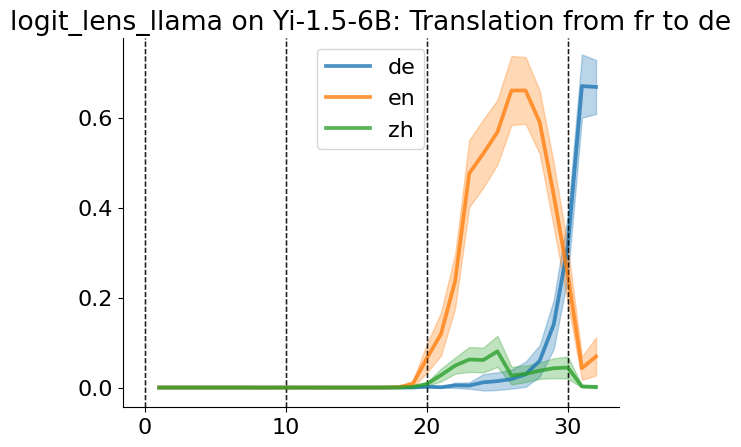

  0%|          | 0/118 [00:00<?, ?it/s]

Found 103 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Maven, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character talk, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

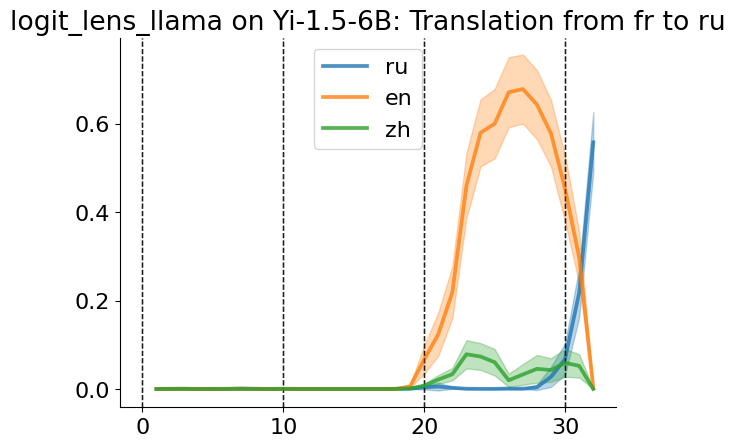

  0%|          | 0/118 [00:00<?, ?it/s]

Found 104 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Maven, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character talk, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

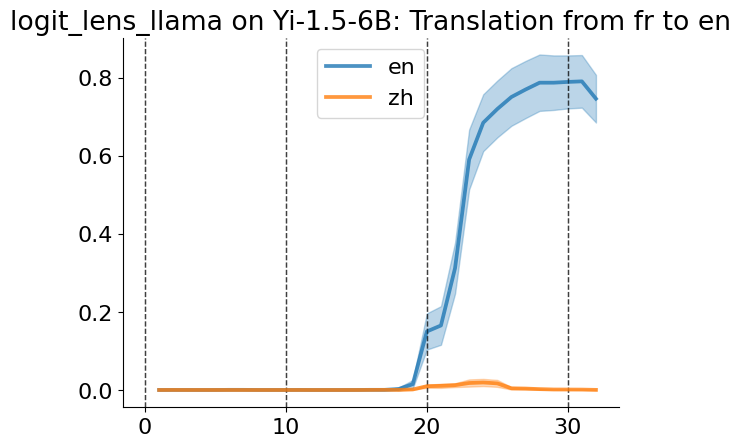

  0%|          | 0/118 [00:00<?, ?it/s]

Found 104 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Maven, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character talk, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

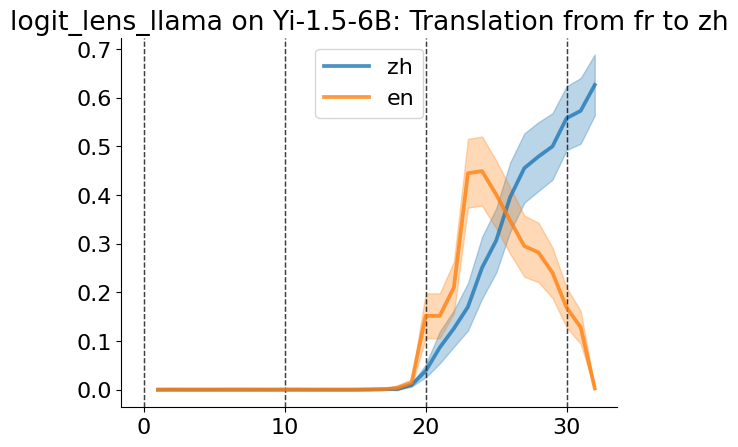

  0%|          | 0/120 [00:00<?, ?it/s]

Found 104 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

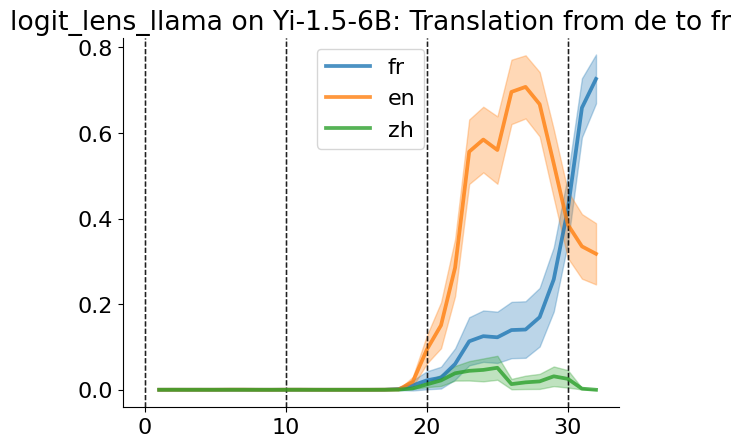

  0%|          | 0/120 [00:00<?, ?it/s]

Found 102 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

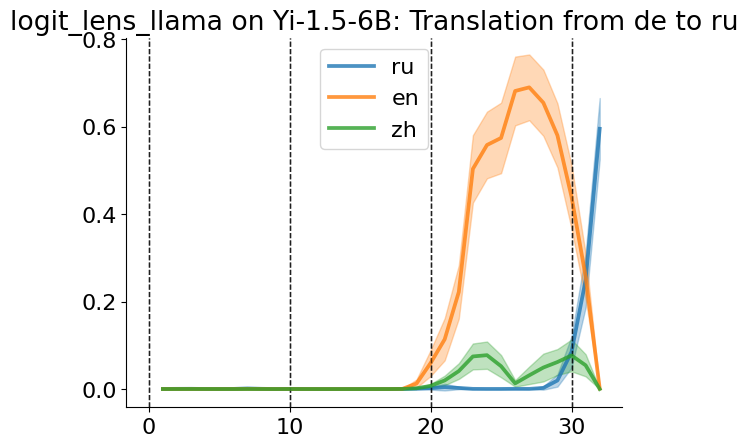

  0%|          | 0/120 [00:00<?, ?it/s]

Found 104 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

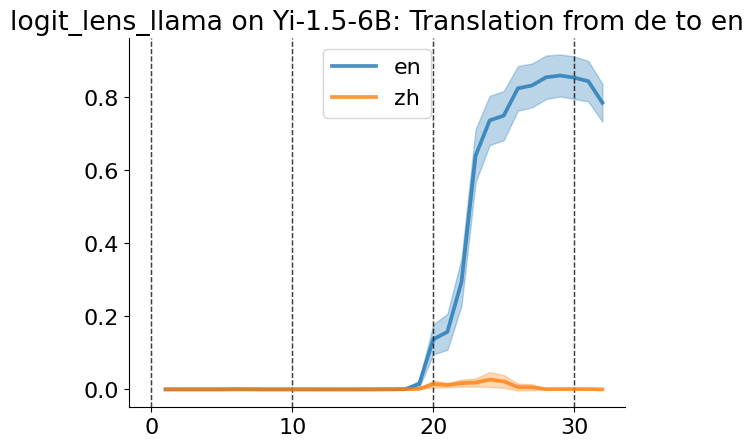

  0%|          | 0/120 [00:00<?, ?it/s]

Found 104 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

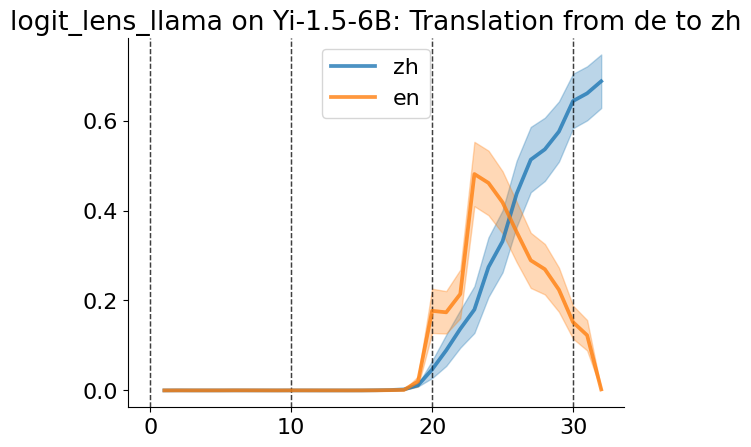

  0%|          | 0/115 [00:00<?, ?it/s]

Found 94 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character panorama, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Elbow_grease, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/3 [00:00<?, ?it/s]

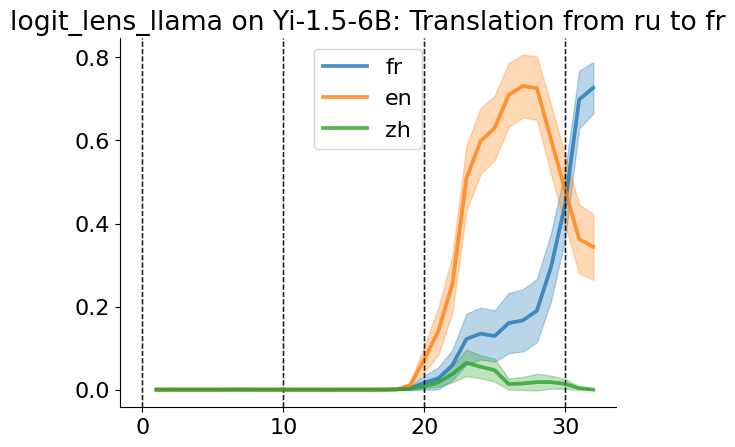

  0%|          | 0/115 [00:00<?, ?it/s]

Found 94 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character panorama, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Elbow_grease, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/3 [00:00<?, ?it/s]

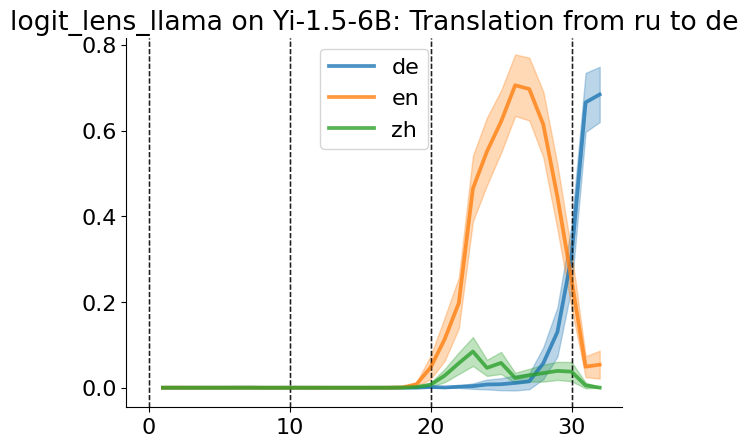

  0%|          | 0/115 [00:00<?, ?it/s]

Found 94 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character panorama, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Elbow_grease, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/3 [00:00<?, ?it/s]

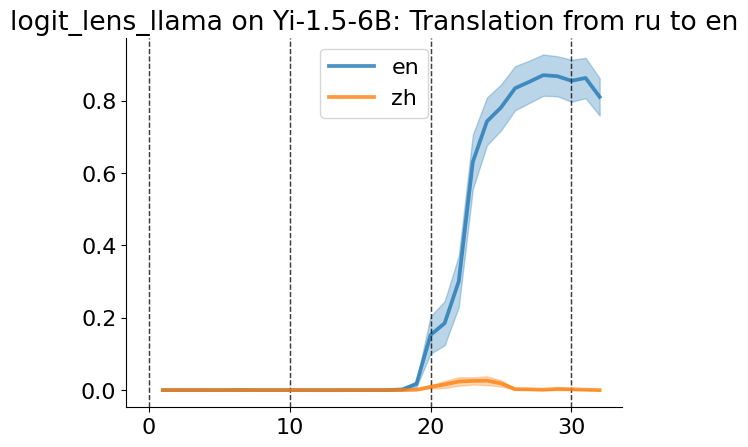

  0%|          | 0/115 [00:00<?, ?it/s]

Found 94 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character panorama, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Elbow_grease, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/3 [00:00<?, ?it/s]

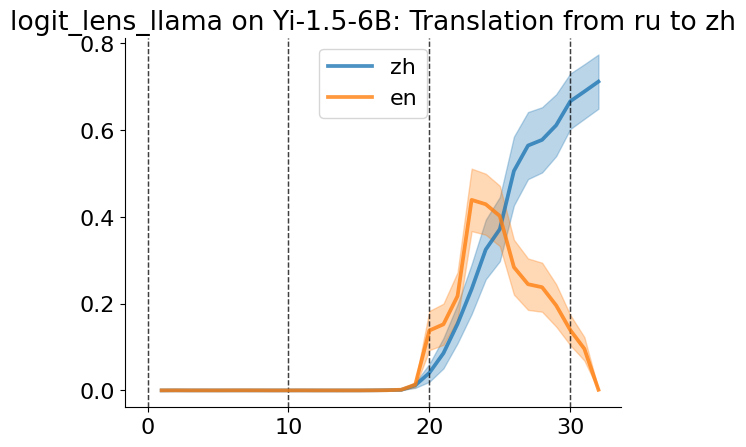

  0%|          | 0/132 [00:00<?, ?it/s]

Found 116 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Maven, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

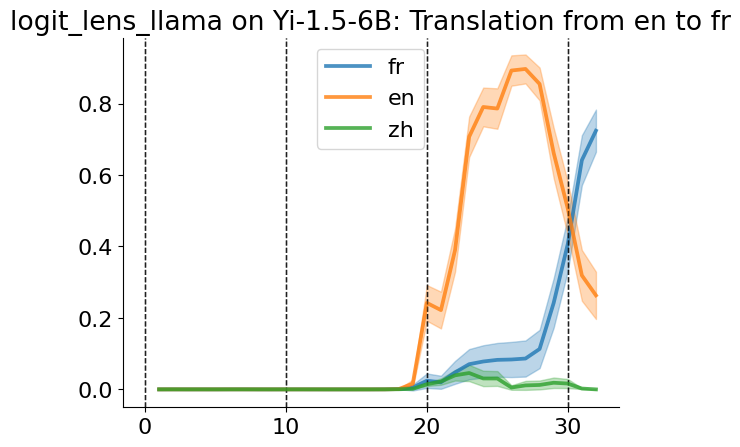

  0%|          | 0/132 [00:00<?, ?it/s]

Found 113 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Maven, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

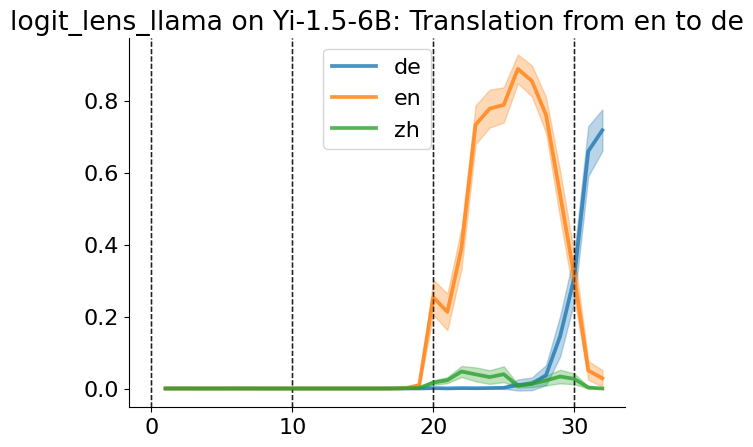

  0%|          | 0/132 [00:00<?, ?it/s]

Found 112 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Maven, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character profit, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

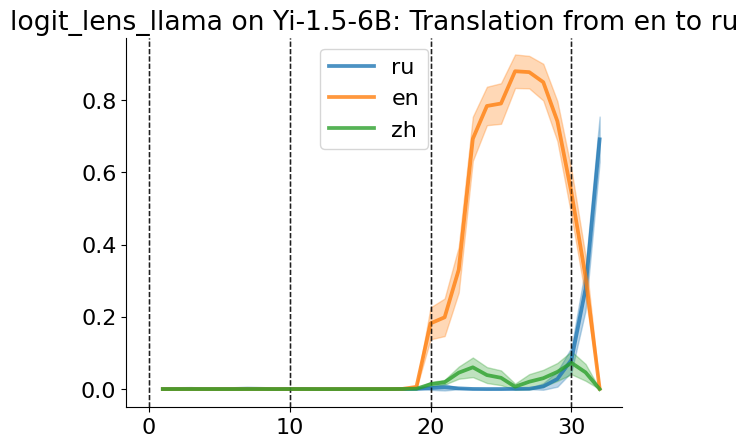

  0%|          | 0/132 [00:00<?, ?it/s]

Found 116 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Maven, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(
/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/4 [00:00<?, ?it/s]

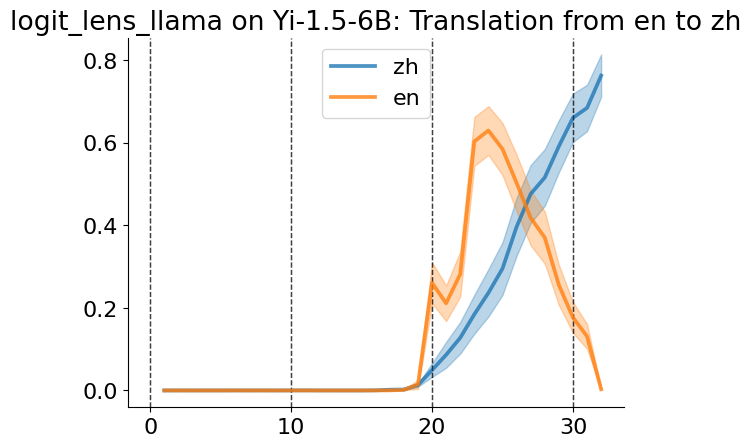

  0%|          | 0/139 [00:00<?, ?it/s]

Found 92 translations


Running prompts:   0%|          | 0/3 [00:00<?, ?it/s]

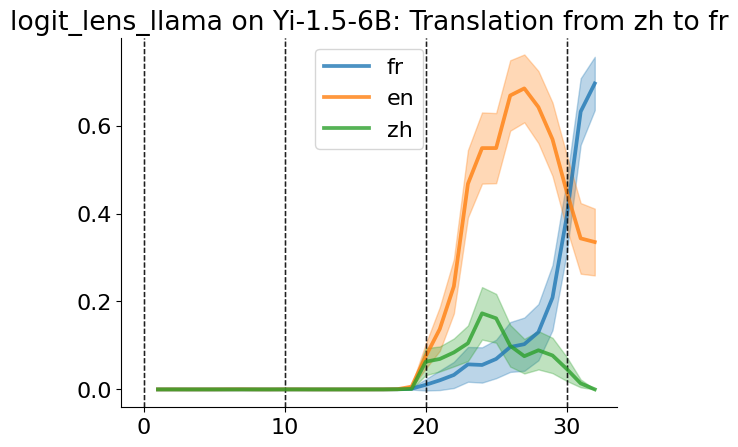

  0%|          | 0/139 [00:00<?, ?it/s]

Found 92 translations


Running prompts:   0%|          | 0/3 [00:00<?, ?it/s]

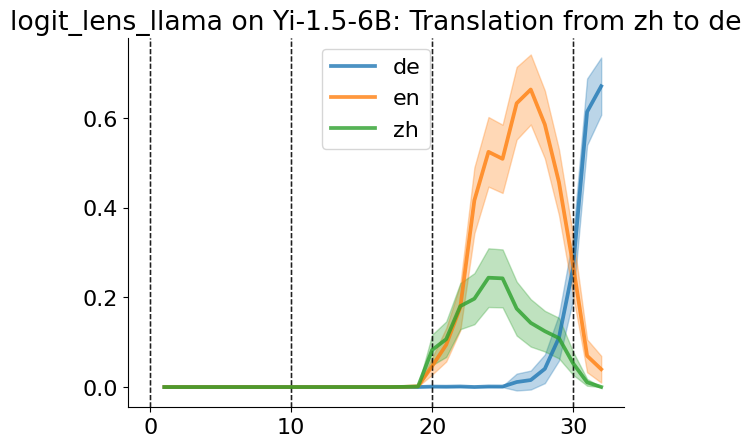

  0%|          | 0/139 [00:00<?, ?it/s]

Found 90 translations


/dlabscratch1/cdumas/llm-latent-language/generalization/../generalization/exp_tools.py:48: UserWarning: Could not encode character Homo_sapiens_sapiens, probably not a valid special character
  warn(


Running prompts:   0%|          | 0/3 [00:00<?, ?it/s]

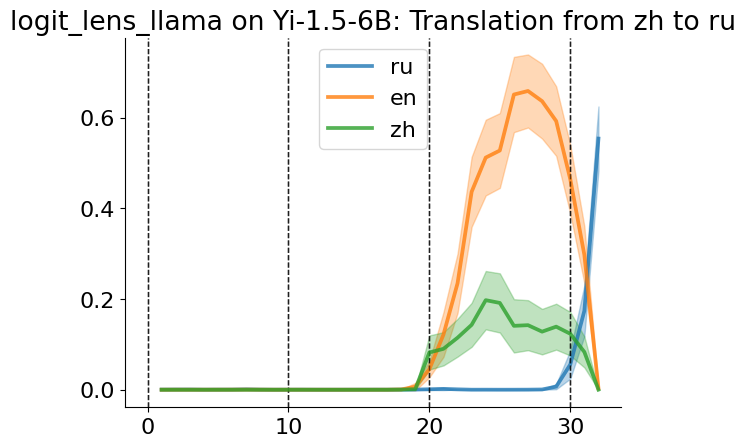

  0%|          | 0/139 [00:00<?, ?it/s]

Found 92 translations


Running prompts:   0%|          | 0/3 [00:00<?, ?it/s]

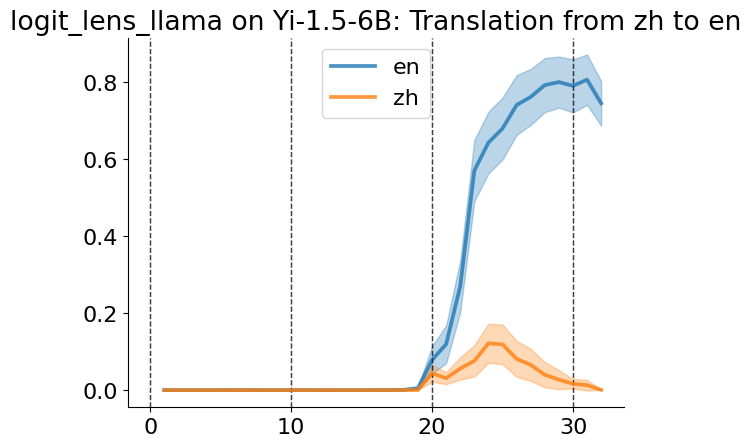

In [9]:
for in_lang in langs:
    for out_lang in out_langs[in_lang]:
        translation_plot(
            in_lang, out_lang, [t for t in thinking_langs if t != out_lang], time_=time_
        )
        plt.show()